In [28]:
# ! pip install Sastrawi
# ! pip install ydata-profiling
# ! pip install gensim

# Import Library

In [86]:
import os, pickle, re
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from gensim.models import Word2Vec
from ydata_profiling import ProfileReport

import nltk, string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.probability import FreqDist
from random import shuffle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.classify import SklearnClassifier
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc

%matplotlib inline

In [30]:
# nltk.download('stopwords')
# nltk.download('punkt')

# Stop word & Stemmer

In [31]:
stop_words = set(stopwords.words('indonesian'))
stemmer = StemmerFactory().create_stemmer()

# Load Dataset

In [32]:
DATA_PATH = './dataset.csv'
df = pd.read_csv(DATA_PATH)

# Exploratory data analysis - EDA

In [33]:
df.head()

,score,text,class
0,8,rt benar yang justru dikuatirkan adalah selama...,Positive
1,0,rt sejumlah orang yang nama diri bagai aktivis...,Neutral
2,8,rt benar yang justru dikuatirkan adalah selama...,Positive
3,-4,rt tentang prabowo subianto indonesia bisa bub...,Negative
4,3,rt indonesian presidential election map by reg...,Positive


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   score   1000 non-null   int64 
 1   text    999 non-null    object
 2   class   1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


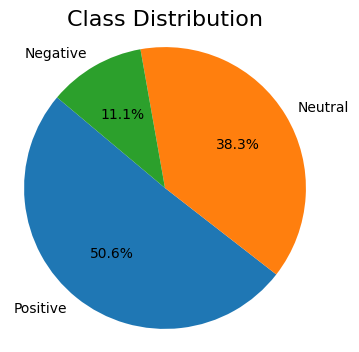

In [35]:
count = df['class'].value_counts()
labels = list(count.index)

plt.figure(figsize=(4, 4))
plt.pie(count, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution', fontsize=16)
plt.axis('equal')  
plt.show()

In [36]:
profile = ProfileReport(df, title = "Profiling")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
def generate_word_cloud(dataframe, text_column, class_column=None, target_class=None):
    if class_column and target_class:
        text_data = dataframe[dataframe[class_column] == target_class][text_column]
    else:
        text_data = dataframe[text_column]

    text_data = text_data.dropna().astype(str)
    
    text_combined = " ".join(text_data)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(target_class + ' Sentiment')
    plt.axis('off')
    plt.show()

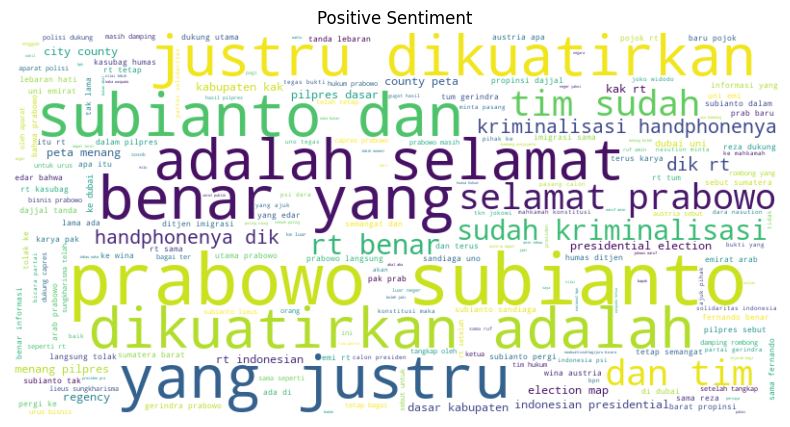

In [38]:
generate_word_cloud(df, text_column='text', class_column='class', target_class='Positive')

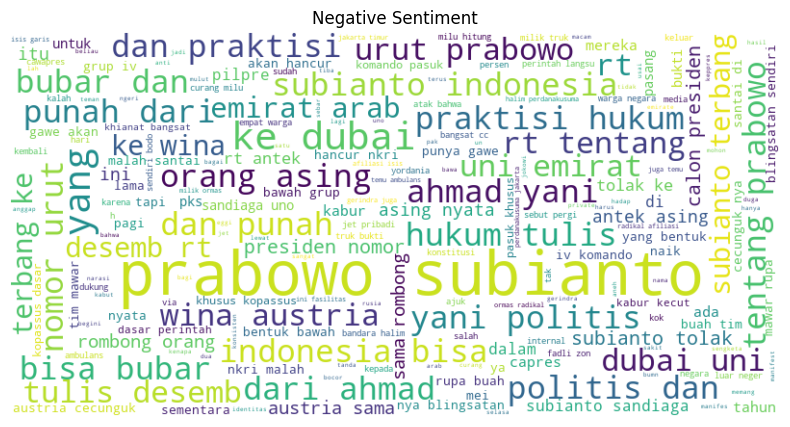

In [39]:
generate_word_cloud(df, text_column='text', class_column='class', target_class='Negative')

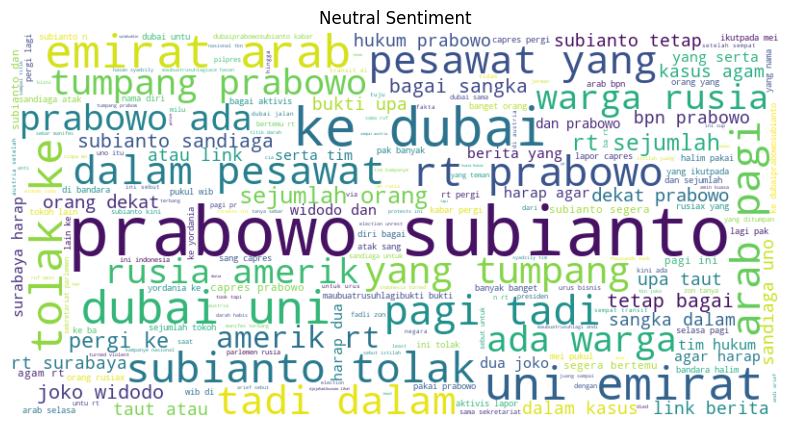

In [40]:
generate_word_cloud(df, text_column='text', class_column='class', target_class='Neutral')

# Preprocessing

In [41]:
df.isna().sum()

score    0
text     1
class    0
dtype: int64

In [42]:
df = df.dropna()

In [43]:
df.isna().sum()

score    0
text     0
class    0
dtype: int64

#### Oversampling 

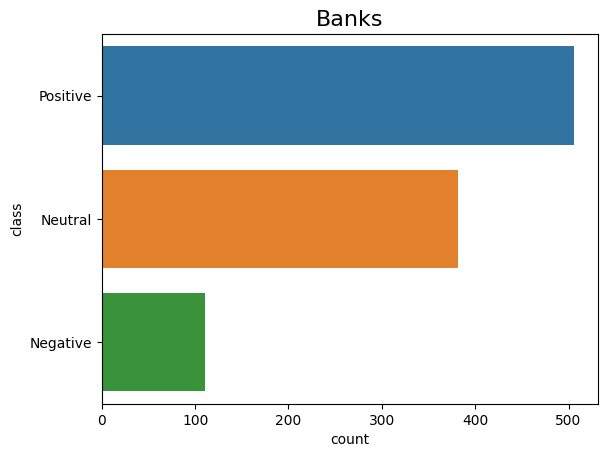

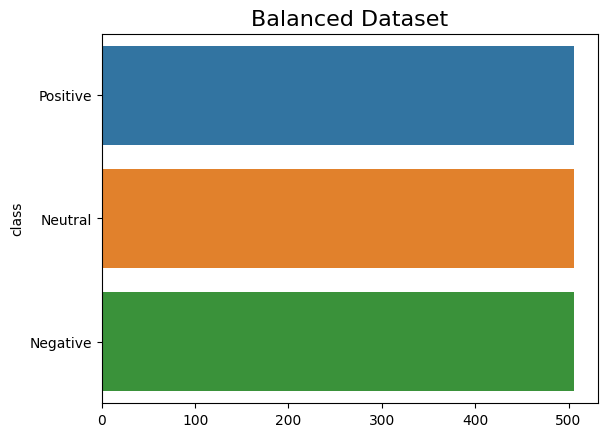

In [44]:
count = df['class'].value_counts()
labels = count.index

plt.title('Banks', fontsize=16)
sns.barplot(x=count, y=labels)

plt.show()

# Oversampling
max_count = count.max()

ros = RandomOverSampler(sampling_strategy={cls: max_count for cls in count.index})

X_resampled, y_resampled = ros.fit_resample(df.drop('class', axis=1), df['class'])

df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=df.drop('class', axis=1).columns),
                          pd.Series(y_resampled, name='class')], axis=1)

count_resampled = df_resampled['class'].value_counts()

plt.title('Balanced Dataset', fontsize=16)
sns.barplot(x=count_resampled.values, y=count_resampled.index)
plt.show()

In [45]:
def preprocessing(document):
    words = word_tokenize(document.lower())
    words = [stemmer.stem(word) for word in words]
    words = [word for word in words if word.isalpha()]
    words = [word for word in words if word not in string.punctuation]
    words = [word for word in words if word not in stop_words]
    return words

df['text_preprocessed'] = df['text'].apply(preprocessing)

C:\Users\User\AppData\Local\Temp\ipykernel_254744\722596889.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_preprocessed'] = df['text'].apply(preprocessing)


In [58]:
df['text_preprocessed'] = df['text_preprocessed'].apply(lambda x: ' '.join(x))

C:\Users\User\AppData\Local\Temp\ipykernel_254744\1021657972.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_preprocessed'] = df['text_preprocessed'].apply(lambda x: ' '.join(x))


In [59]:
df.head()

,score,text,class,text_preprocessed
0,8,rt benar yang justru dikuatirkan adalah selama...,Positive,rt dikuatirkan selamat prabowo subianto tim kr...
1,0,rt sejumlah orang yang nama diri bagai aktivis...,Neutral,rt orang nama aktivis lapor capres prabowo sub...
2,8,rt benar yang justru dikuatirkan adalah selama...,Positive,rt dikuatirkan selamat prabowo subianto tim kr...
3,-4,rt tentang prabowo subianto indonesia bisa bub...,Negative,rt prabowo subianto indonesia bubar punah ahma...
4,3,rt indonesian presidential election map by reg...,Positive,rt indonesian presidential election map by reg...


# TFIDF

In [60]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_preprocessed'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

df_tfidf = pd.concat([df[['text_preprocessed', 'class']], tfidf_df], axis=1)

df_tfidf.head()

,text_preprocessed,class,aba,abadi,abal,accept,aceh,adnan,advokasi,afiliasi,...,wonderdirpilpres,wowo,ya,yani,yordania,your,yudhoyono,yuk,yusril,zon
0,rt dikuatirkan selamat prabowo subianto tim kr...,Positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,rt orang nama aktivis lapor capres prabowo sub...,Neutral,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,rt dikuatirkan selamat prabowo subianto tim kr...,Positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,rt prabowo subianto indonesia bubar punah ahma...,Negative,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.326013,0.0,0.0,0.0,0.0,0.0,0.0
4,rt indonesian presidential election map by reg...,Positive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


# Word2Vec

#### Get the word vector for the word 'prabowo'

In [63]:
tokenized_text = [word_tokenize(text.lower()) for text in df['text_preprocessed']]

word2vec_model = Word2Vec(tokenized_text, vector_size=100, window=5, min_count=1, sg=0)

word2vec_model.save("word2vec_model")

vector_prabowo = word2vec_model.wv['prabowo']
print(vector_prabowo)

[-0.05282127  0.14857729 -0.11540895  0.12424222 -0.04852989 -0.2878818
  0.21796253  0.48599276 -0.20900202 -0.16671932 -0.00378714 -0.36132726
 -0.08934871  0.3323595  -0.12838273 -0.33279753  0.15331428 -0.1167644
 -0.24638751 -0.50017434  0.3410948  -0.02557372  0.1974174  -0.34397087
  0.12438661 -0.17721331 -0.06739727 -0.1528712  -0.16304094  0.02819225
  0.16555536  0.02023284  0.204187   -0.26177713 -0.1396584   0.23150766
  0.18127917 -0.1507078  -0.12235706 -0.32278857  0.07847397 -0.14196202
 -0.08678588 -0.06722625  0.20386207 -0.15201755 -0.09359614 -0.03783933
  0.22783157  0.12015063  0.17316845 -0.2127814   0.07905187 -0.11135657
 -0.09685739  0.16272467  0.2613181   0.02323718 -0.31343302  0.23983309
  0.09970914  0.01251546  0.17566633 -0.04780705 -0.21697308  0.224639
 -0.01294594  0.4058794  -0.47930807  0.5542376   0.02198303  0.2691762
  0.33603093 -0.06393202  0.27316427 -0.16902584  0.03212372  0.05076897
 -0.19906537  0.00340411 -0.15898548 -0.17899132 -0.3603

#### Finds  words similar to 'prabowo' based on their word vectors

In [64]:
similar_words_prabowo = word2vec_model.wv.most_similar('prabowo')
print(similar_words_prabowo)

[('subianto', 0.9990127086639404), ('dubai', 0.9987272620201111), ('pergi', 0.9986213445663452), ('sandiaga', 0.9983315467834473), ('rt', 0.9980581402778625), ('indonesia', 0.9980089068412781), ('rombong', 0.9979463815689087), ('ditjen', 0.9979400038719177), ('imigrasi', 0.9979287385940552), ('widodo', 0.9979161024093628)]


# Model Training

In [78]:
def check_scores(clf, X_train, X_test, y_train, y_test):
    model = OneVsRestClassifier(clf).fit(X_train, y_train)
    predicted_class = model.predict(X_test)
    predicted_class_train = model.predict(X_train)
    train_probs = model.predict_proba(X_train)
    test_probs = model.predict_proba(X_test)

    lb = LabelBinarizer()
    y_train_binarized = lb.fit_transform(y_train)
    y_test_binarized = lb.transform(y_test)

    # Calculate micro-average AUC
    train_auc = roc_auc_score(y_train_binarized, train_probs, average='micro')
    test_auc = roc_auc_score(y_test_binarized, test_probs, average='micro')

    # Calculate F1 score
    train_f1 = f1_score(y_train, predicted_class_train, average='macro')
    test_f1 = f1_score(y_test, predicted_class, average='macro')

    print('Train confusion matrix:')
    print(confusion_matrix(y_train, predicted_class_train))
    print('\nTest confusion matrix:')
    print(confusion_matrix(y_test, predicted_class))
    print('\nClassification report:')
    print(classification_report(y_test, predicted_class))
    print()

    train_accuracy = accuracy_score(y_train, predicted_class_train)
    test_accuracy = accuracy_score(y_test, predicted_class)

    print("Train accuracy score:", train_accuracy)
    print("Test accuracy score:", test_accuracy)
    print()
    print("Train ROC-AUC score:", train_auc)
    print("Test ROC-AUC score:", test_auc)

    # Precision-Recall curve and ROC curve plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Precision-Recall curve for each class
    for i in range(len(lb.classes_)):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], test_probs[:, i])
        ax1.plot(recall, precision, lw=2, label='Class {}'.format(lb.classes_[i]))
    
    ax1.set_xlabel("Recall")
    ax1.set_ylabel("Precision")
    ax1.legend(loc="best")
    ax1.set_title("Precision-Recall curve")

    # ROC curve for each class
    for i in range(len(lb.classes_)):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], test_probs[:, i])
        ax2.plot(fpr, tpr, lw=2, label='Class {}'.format(lb.classes_[i]))
    
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.legend(loc="best")
    ax2.set_title("ROC curve")

    plt.subplots_adjust(left=0.1, bottom=0.1, right=1.0, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()

    print("Area under Precision-Recall curve (macro):", test_f1)
    print()

    return train_accuracy, test_accuracy, train_auc, test_auc

#### SVM 

In [80]:
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.text_preprocessed)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['class'], random_state=42)

Train confusion matrix:
[[ 91   0   0]
 [  0 286   0]
 [  0   0 372]]

Test confusion matrix:
[[ 11   9   0]
 [  1  94   1]
 [  1   7 126]]

Classification report:
              precision    recall  f1-score   support

    Negative       0.85      0.55      0.67        20
     Neutral       0.85      0.98      0.91        96
    Positive       0.99      0.94      0.97       134

    accuracy                           0.92       250
   macro avg       0.90      0.82      0.85       250
weighted avg       0.93      0.92      0.92       250


Train accuracy score: 1.0
Test accuracy score: 0.924

Train ROC-AUC score: 1.0
Test ROC-AUC score: 0.990008


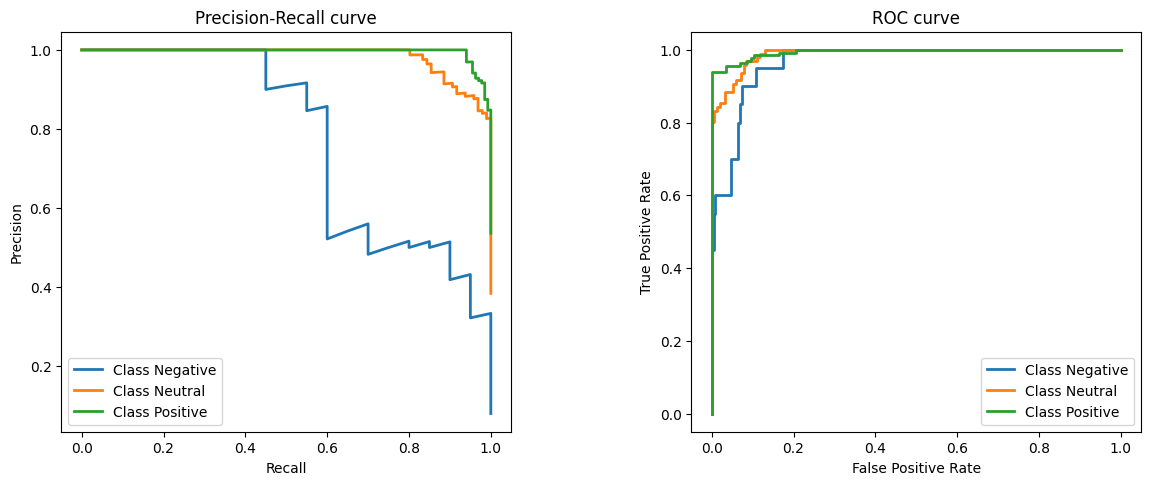

Area under Precision-Recall curve (macro): 0.8482684224230926



In [81]:
SVM = svm.SVC( probability=True)
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM,x_train, x_test, y_train, y_test)

In [87]:
joblib.dump(SVM, 'svm_model.joblib')

['svm_model.joblib']

#### Naive Bayes Model

Train confusion matrix:
[[ 75  16   0]
 [  0 279   7]
 [  0  19 353]]

Test confusion matrix:
[[  9  10   1]
 [  2  86   8]
 [  2  12 120]]

Classification report:
              precision    recall  f1-score   support

    Negative       0.69      0.45      0.55        20
     Neutral       0.80      0.90      0.84        96
    Positive       0.93      0.90      0.91       134

    accuracy                           0.86       250
   macro avg       0.81      0.75      0.77       250
weighted avg       0.86      0.86      0.86       250


Train accuracy score: 0.9439252336448598
Test accuracy score: 0.86

Train ROC-AUC score: 0.9902825485159562
Test ROC-AUC score: 0.9808239999999999


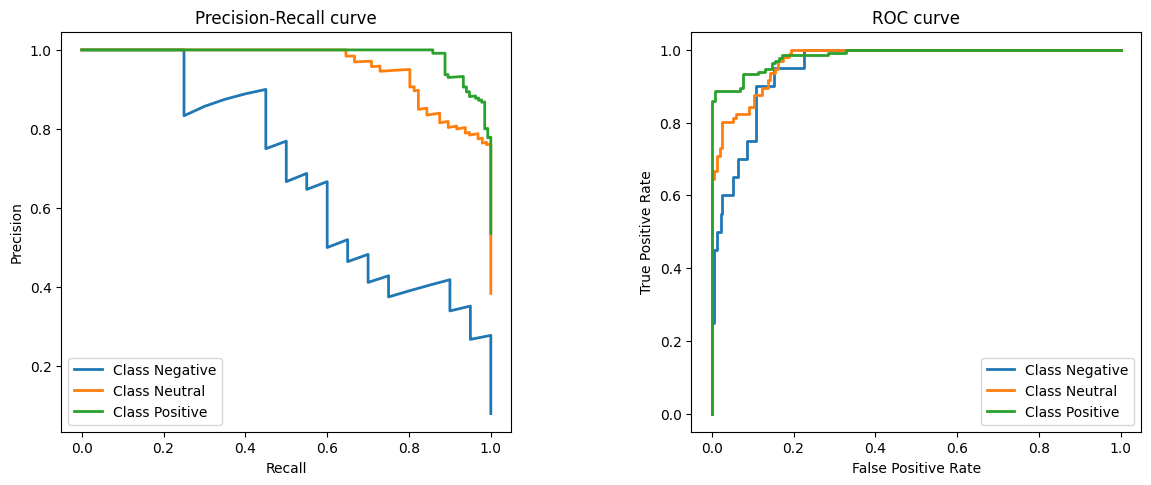

Area under Precision-Recall curve (macro): 0.7670464429578722



In [84]:
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(MultinomialNB(),x_train, x_test, y_train, y_test)

In [88]:
nb_model = MultinomialNB().fit(x_train, y_train)
joblib.dump(nb_model, 'multinomial_nb_model.joblib')

['multinomial_nb_model.joblib']